In [1]:
!git clone https://github.com/sami-ka/gnn_slotting_optimization.git

fatal: destination path 'gnn_slotting_optimization' already exists and is not an empty directory.


In [2]:
! pip install polars>=1.36.1
! pip install pyzmq>=27.1.0 scipy>=1.16.3 torch>=2.9.1 torch-geometric==2.4.0

In [3]:
from pathlib import Path
import sys

root = Path("/")

sys.path.insert(0, "/content/gnn_slotting_optimization" )

In [4]:
from slotting_optimization.generator import DataGenerator
from slotting_optimization.order_book import OrderBook
from slotting_optimization.item_locations import ItemLocations
from slotting_optimization.warehouse import Warehouse

gen = DataGenerator()
samples = gen.generate_samples(20, 20, 300, 1, 10, n_samples=10000, distances_fixed=True, seed=5)

In [5]:
from slotting_optimization.gnn_builder import build_graph_sparse
from slotting_optimization.simulator import Simulator
list_data = []
for (ob, il, w) in samples:
    g_data = build_graph_sparse(
    order_book=ob,
    item_locations=il,
    warehouse=w,
    simulator=Simulator().simulate
)
    list_data.append(g_data)


In [6]:
import torch
torch.manual_seed(12345)
train_split_idx = int(0.8 * len(list_data))
train_dataset = list_data[:train_split_idx]
test_dataset = list_data[train_split_idx:]

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    break

Step 1:
Number of graphs in the current batch: 128
DataBatch(edge_index=[2, 108731], edge_attr=[108731, 1], num_nodes=5376, n_items=[128], n_locs=[128], n_storage=[128], items_list=[128], locs_list=[128], y=[128], batch=[5376], ptr=[129])



In [8]:
from torch import nn
from torch_geometric.nn import MessagePassing, global_add_pool

In [9]:
class EdgeThenNodeLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim):
        super().__init__(aggr="add")
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, edge_dim),
            nn.ReLU(),
            nn.Linear(edge_dim, edge_dim),
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + edge_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )

    def forward(self, x, edge_index, edge_attr):
        row, col = edge_index
        edge_attr = self.edge_mlp(
            torch.cat([x[row], x[col], edge_attr], dim=1)
        )
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return x, edge_attr

    def message(self, x_j, edge_attr):
        return self.node_mlp(torch.cat([x_j, edge_attr], dim=1))

In [10]:
class NodeThenEdgeLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim):
        super().__init__(aggr="add")
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + edge_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, edge_dim),
            nn.ReLU(),
            nn.Linear(edge_dim, edge_dim),
        )

    def forward(self, x, edge_index, edge_attr):
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        row, col = edge_index
        edge_attr = self.edge_mlp(
            torch.cat([x[row], x[col], edge_attr], dim=1)
        )
        return x, edge_attr

    def message(self, x_j, edge_attr):
        return self.node_mlp(torch.cat([x_j, edge_attr], dim=1))

In [11]:
class GCNBlock(nn.Module):
    def __init__(self, node_dim, edge_dim):
        super().__init__()
        self.edge_then_node = EdgeThenNodeLayer(node_dim, edge_dim)
        self.node_then_edge = NodeThenEdgeLayer(node_dim, edge_dim)

    def forward(self, x, edge_index, edge_attr):
        x, edge_attr = self.edge_then_node(x, edge_index, edge_attr)
        x, edge_attr = self.node_then_edge(x, edge_index, edge_attr)
        return x, edge_attr

In [12]:
class GraphRegressionModel(nn.Module):
    def __init__(self, num_nodes, edge_dim, hidden_dim, num_layers):
        super().__init__()

        self.node_embedding = nn.Embedding(num_nodes, hidden_dim)
        self.edge_encoder = nn.Linear(edge_dim, hidden_dim)

        self.layers = nn.ModuleList(
            [GCNBlock(hidden_dim, hidden_dim) for _ in range(num_layers)]
        )

        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, data):
        node_ids = torch.arange(data.num_nodes, device=data.edge_index.device)
        x = self.node_embedding(node_ids)
        edge_attr = self.edge_encoder(data.edge_attr)

        for layer in self.layers:
            x, edge_attr = layer(x, data.edge_index, edge_attr)

        graph_emb = global_add_pool(x, data.batch)
        out = self.regressor(graph_emb)
        return out.squeeze(-1)

In [13]:
model = GraphRegressionModel(num_nodes=data.num_nodes,
            edge_dim=data.num_edge_features,
            hidden_dim=3,
            num_layers=3)
print(model)

GraphRegressionModel(
  (node_embedding): Embedding(5376, 3)
  (edge_encoder): Linear(in_features=1, out_features=3, bias=True)
  (layers): ModuleList(
    (0-2): 3 x GCNBlock(
      (edge_then_node): EdgeThenNodeLayer()
      (node_then_edge): NodeThenEdgeLayer()
    )
  )
  (regressor): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
)


In [14]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


True
Tesla T4


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

inputs = data.to(device)
targets = data.y.to(device)

Epoch: 001, Train MSE: 918870.6855, Val MSE: 882986.1240
Epoch: 002, Train MSE: 901481.8470, Val MSE: 863372.4880
Epoch: 003, Train MSE: 865756.5690, Val MSE: 820836.2260
Epoch: 004, Train MSE: 863111.8270, Val MSE: 817322.2340
Epoch: 005, Train MSE: 866788.9440, Val MSE: 810000.0920
Epoch: 006, Train MSE: 897695.2300, Val MSE: 834936.2720
Epoch: 007, Train MSE: 864225.5760, Val MSE: 818805.7640
Epoch: 008, Train MSE: 900418.2600, Val MSE: 862143.5820
Epoch: 009, Train MSE: 962452.3250, Val MSE: 892444.3560
Epoch: 010, Train MSE: 858790.5660, Val MSE: 805086.9160


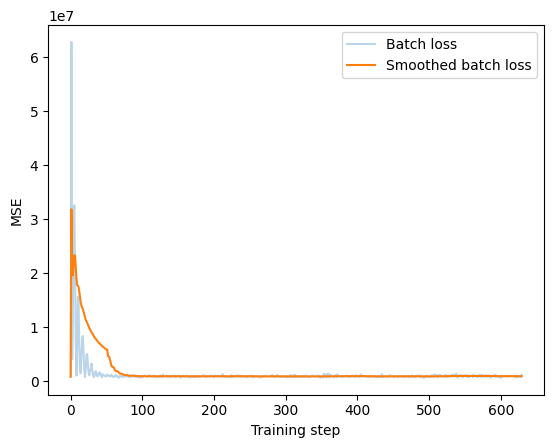

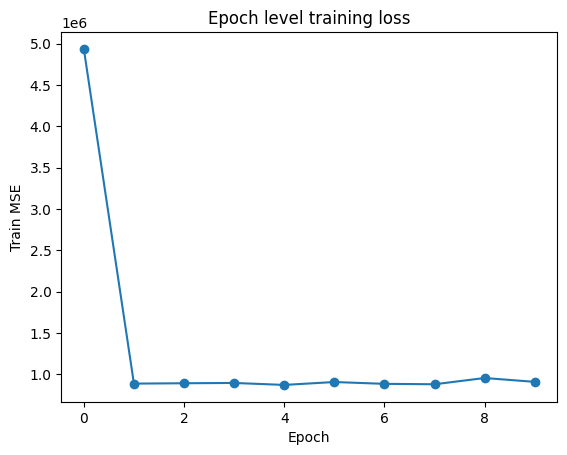

Epoch: 011, Train MSE: 901600.6320, Val MSE: 838267.1320
Epoch: 012, Train MSE: 860581.4860, Val MSE: 805961.9180
Epoch: 013, Train MSE: 870207.7000, Val MSE: 826440.1760
Epoch: 014, Train MSE: 857707.9965, Val MSE: 804741.1320
Epoch: 015, Train MSE: 879302.5590, Val MSE: 819572.1160
Epoch: 016, Train MSE: 856516.3755, Val MSE: 804968.4380
Epoch: 017, Train MSE: 935098.9310, Val MSE: 900920.5080
Epoch: 018, Train MSE: 983920.6750, Val MSE: 911995.6840
Epoch: 019, Train MSE: 870386.8630, Val MSE: 812588.9740
Epoch: 020, Train MSE: 856624.2355, Val MSE: 805114.8160


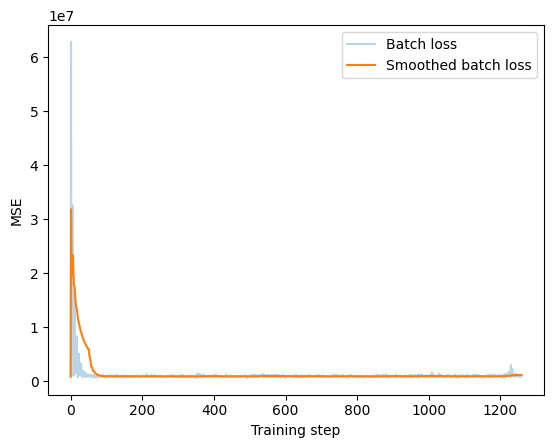

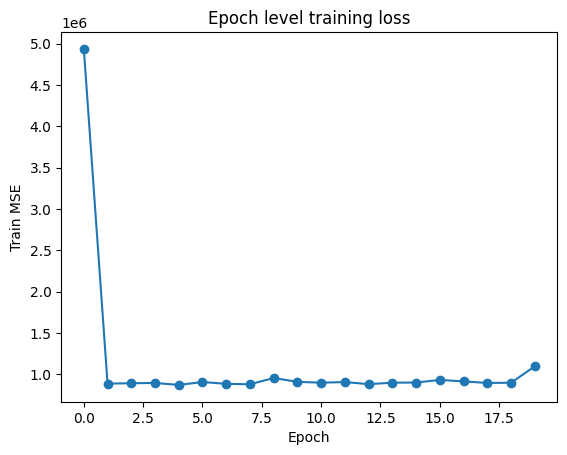

Epoch: 021, Train MSE: 936224.4435, Val MSE: 868635.3720
Epoch: 022, Train MSE: 856622.6735, Val MSE: 805620.5720
Epoch: 023, Train MSE: 856645.8450, Val MSE: 805591.6720
Epoch: 024, Train MSE: 861232.7220, Val MSE: 806301.7560
Epoch: 025, Train MSE: 877920.7980, Val MSE: 818353.0460
Epoch: 026, Train MSE: 857093.6040, Val MSE: 805066.1360
Epoch: 027, Train MSE: 861747.9080, Val MSE: 814865.8000
Epoch: 028, Train MSE: 867535.2365, Val MSE: 822575.9060
Epoch: 029, Train MSE: 1171408.8650, Val MSE: 1153527.9960
Epoch: 030, Train MSE: 859014.4880, Val MSE: 805277.3760


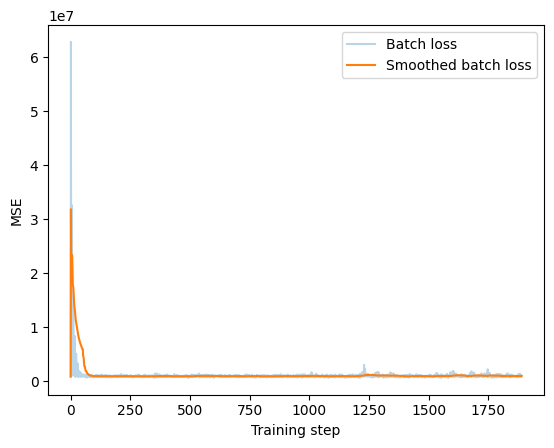

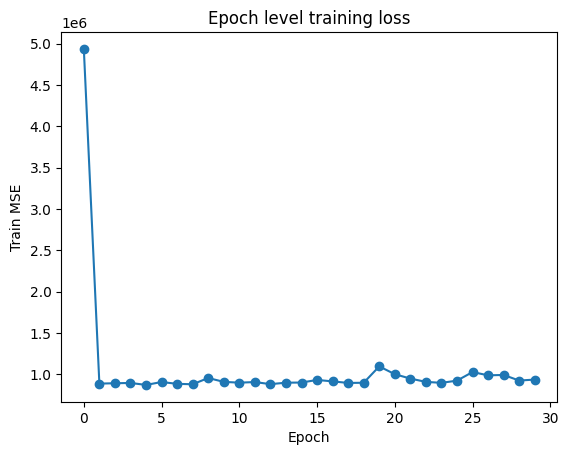

Epoch: 031, Train MSE: 1145684.7860, Val MSE: 1062771.4200
Epoch: 032, Train MSE: 866641.2365, Val MSE: 821279.8820
Epoch: 033, Train MSE: 978978.8920, Val MSE: 907129.1760
Epoch: 034, Train MSE: 900473.9930, Val MSE: 861549.2580
Epoch: 035, Train MSE: 1050527.7210, Val MSE: 973254.4760
Epoch: 036, Train MSE: 900430.7675, Val MSE: 836871.6640
Epoch: 037, Train MSE: 1385094.5280, Val MSE: 1376801.8000
Epoch: 038, Train MSE: 861322.2615, Val MSE: 813530.5680
Epoch: 039, Train MSE: 859441.1125, Val MSE: 805596.9520
Epoch: 040, Train MSE: 981361.5915, Val MSE: 909122.5200


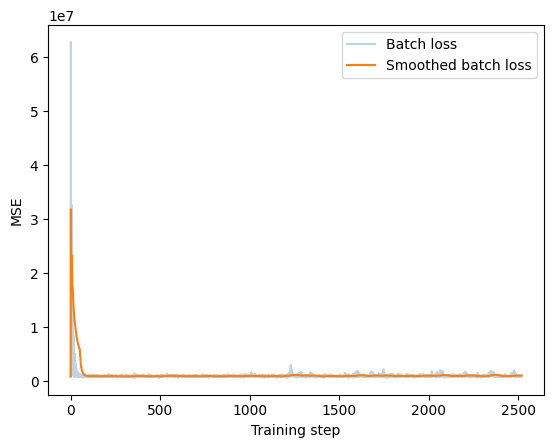

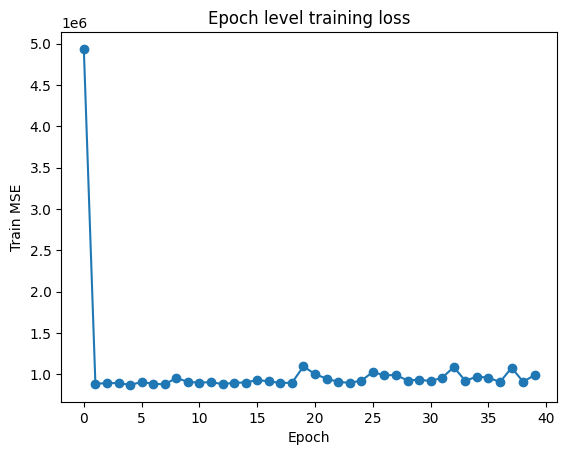

Epoch: 041, Train MSE: 936823.2730, Val MSE: 868716.8840
Epoch: 042, Train MSE: 878967.6820, Val MSE: 818900.6720
Epoch: 043, Train MSE: 982492.0810, Val MSE: 910069.8680
Epoch: 044, Train MSE: 872422.8880, Val MSE: 827948.7840
Epoch: 045, Train MSE: 950427.4645, Val MSE: 880858.9120
Epoch: 046, Train MSE: 1025120.4120, Val MSE: 949302.7080
Epoch: 047, Train MSE: 870137.2615, Val MSE: 812077.2940
Epoch: 048, Train MSE: 871817.7960, Val MSE: 813310.4320
Epoch: 049, Train MSE: 906203.6450, Val MSE: 867438.3700
Epoch: 050, Train MSE: 907470.4540, Val MSE: 868800.1980


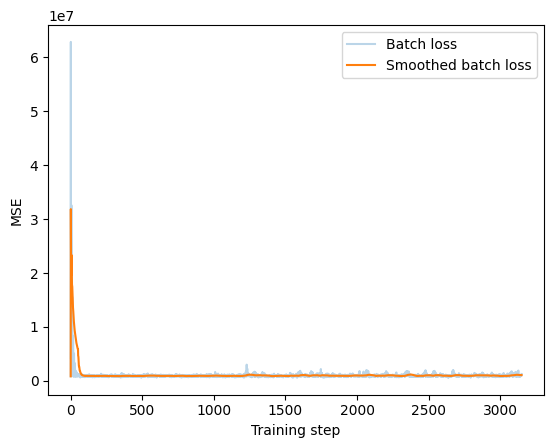

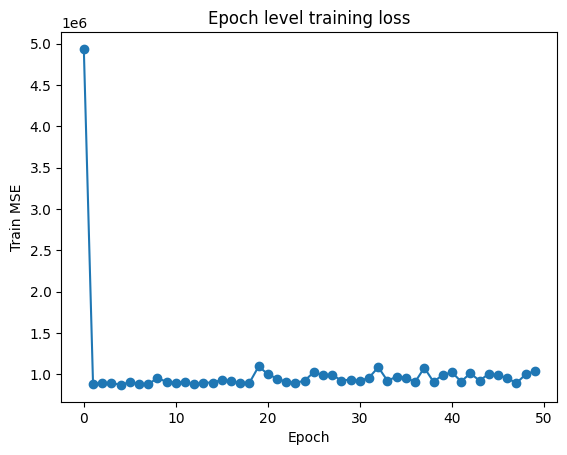

Epoch: 051, Train MSE: 1033829.0900, Val MSE: 957256.0120
Epoch: 052, Train MSE: 929793.8520, Val MSE: 893765.7840
Epoch: 053, Train MSE: 1657782.4520, Val MSE: 1658909.4280
Epoch: 054, Train MSE: 861630.4160, Val MSE: 812774.0360
Epoch: 055, Train MSE: 867628.4655, Val MSE: 821235.8720
Epoch: 056, Train MSE: 883143.0470, Val MSE: 840444.5480
Epoch: 057, Train MSE: 864202.5220, Val MSE: 808100.2720
Epoch: 058, Train MSE: 872215.7570, Val MSE: 827040.7660
Epoch: 059, Train MSE: 892494.9800, Val MSE: 851355.2640
Epoch: 060, Train MSE: 1203713.2870, Val MSE: 1116980.7680


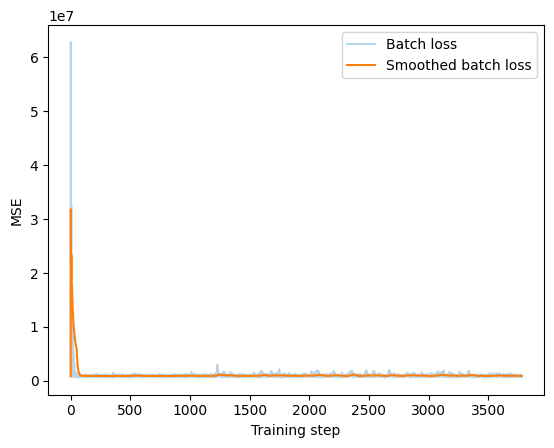

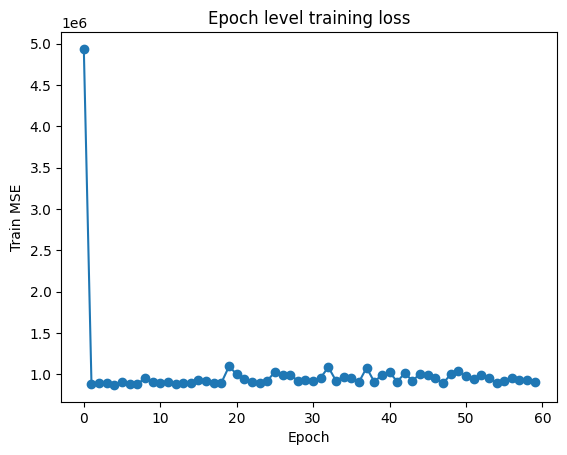

Epoch: 061, Train MSE: 863441.7605, Val MSE: 807703.1320
Epoch: 062, Train MSE: 1025965.1690, Val MSE: 998141.7360
Epoch: 063, Train MSE: 1533035.0930, Val MSE: 1432372.4720
Epoch: 064, Train MSE: 869878.9960, Val MSE: 823823.6520
Epoch: 065, Train MSE: 861384.3200, Val MSE: 811758.0740
Epoch: 066, Train MSE: 894355.6180, Val MSE: 853287.8640
Epoch: 067, Train MSE: 1336205.2980, Val MSE: 1325021.8400
Epoch: 068, Train MSE: 905118.7590, Val MSE: 865603.9060
Epoch: 069, Train MSE: 890652.5165, Val MSE: 828125.9640
Epoch: 070, Train MSE: 862818.5635, Val MSE: 807499.8960


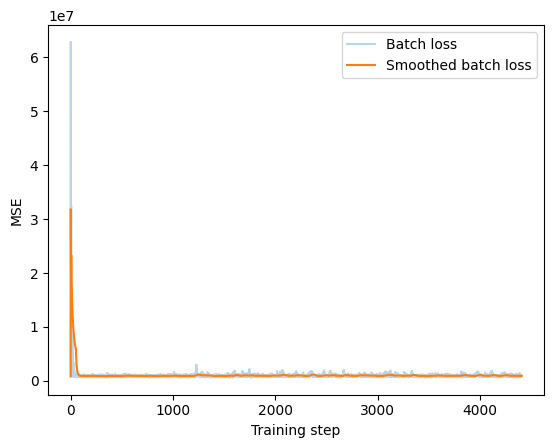

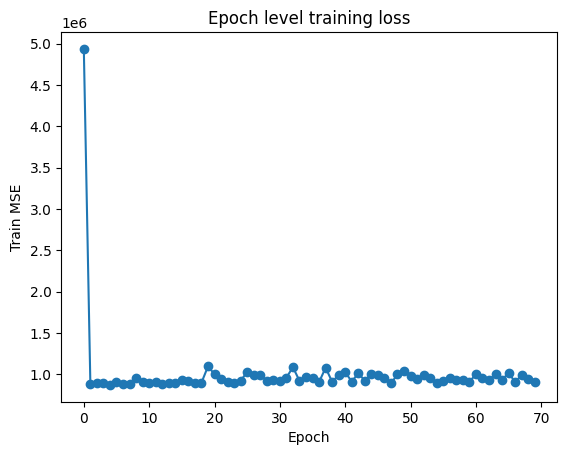

Epoch: 071, Train MSE: 870245.3595, Val MSE: 812087.5480
Epoch: 072, Train MSE: 889329.7365, Val MSE: 827018.9440
Epoch: 073, Train MSE: 902142.5490, Val MSE: 862140.6780
Epoch: 074, Train MSE: 860910.1200, Val MSE: 810435.2780
Epoch: 075, Train MSE: 870332.1505, Val MSE: 824146.9280
Epoch: 076, Train MSE: 860131.0740, Val MSE: 807641.1180
Epoch: 077, Train MSE: 1086377.4730, Val MSE: 1062383.7640
Epoch: 078, Train MSE: 865072.5880, Val MSE: 817007.1920
Epoch: 079, Train MSE: 860206.9780, Val MSE: 808043.7920
Epoch: 080, Train MSE: 894148.2600, Val MSE: 831002.5280


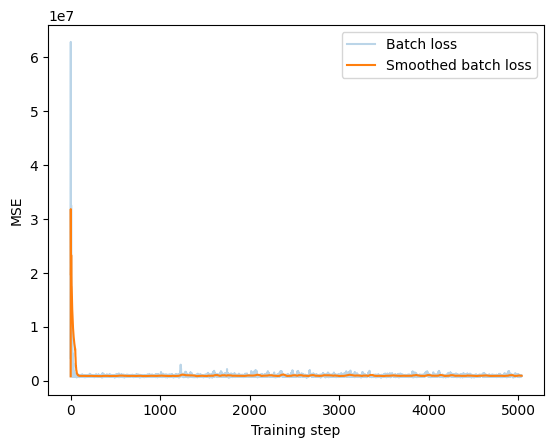

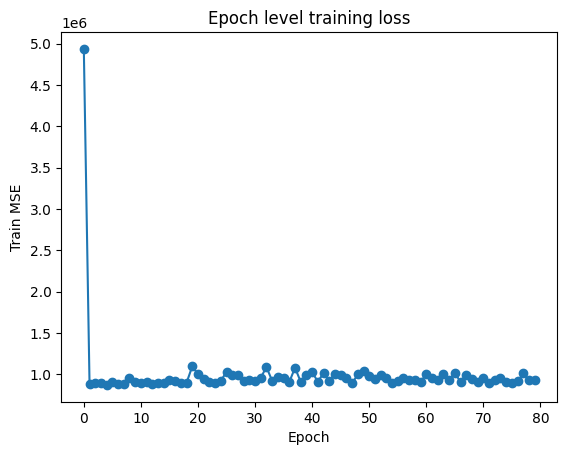

Epoch: 081, Train MSE: 907260.0230, Val MSE: 842174.8320
Epoch: 082, Train MSE: 915910.7610, Val MSE: 849690.6300
Epoch: 083, Train MSE: 1456792.4860, Val MSE: 1358749.5040
Epoch: 084, Train MSE: 939792.0680, Val MSE: 870819.1360
Epoch: 085, Train MSE: 960495.1380, Val MSE: 926998.1840
Epoch: 086, Train MSE: 989325.2235, Val MSE: 915766.3960
Epoch: 087, Train MSE: 939665.0225, Val MSE: 904089.8040
Epoch: 088, Train MSE: 943643.4930, Val MSE: 874261.0920
Epoch: 089, Train MSE: 867144.0810, Val MSE: 810000.8000
Epoch: 090, Train MSE: 903502.3360, Val MSE: 838915.4860


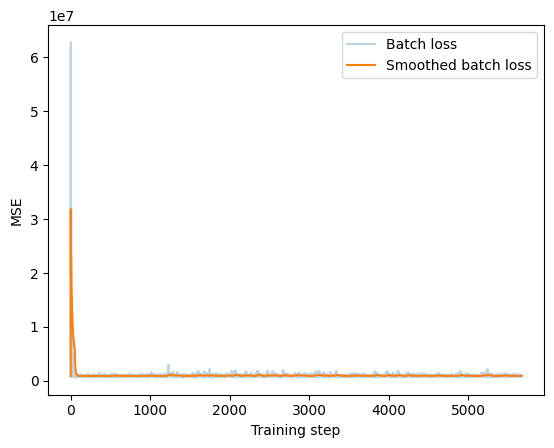

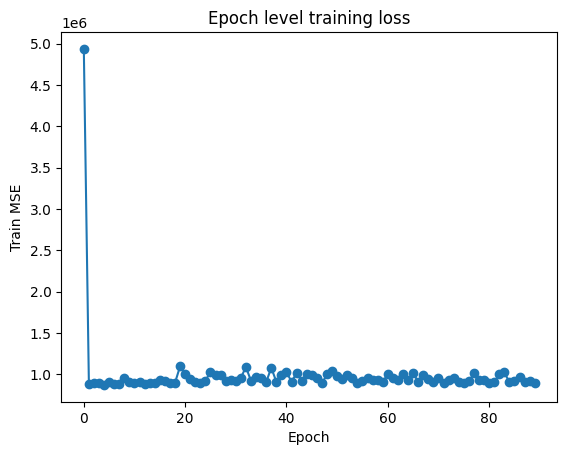

Epoch: 091, Train MSE: 1204956.6290, Val MSE: 1117865.9600
Epoch: 092, Train MSE: 1088087.2310, Val MSE: 1007502.9640
Epoch: 093, Train MSE: 866668.0780, Val MSE: 819026.6700
Epoch: 094, Train MSE: 949195.5320, Val MSE: 914553.8860
Epoch: 095, Train MSE: 946737.9690, Val MSE: 911848.8520
Epoch: 096, Train MSE: 869816.1485, Val MSE: 811789.4140
Epoch: 097, Train MSE: 860653.3660, Val MSE: 807639.4280
Epoch: 098, Train MSE: 931561.8480, Val MSE: 895060.3360
Epoch: 099, Train MSE: 939056.2775, Val MSE: 870129.0420


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

import matplotlib.pyplot as plt

train_batch_losses = []
train_epoch_losses = []

def train():
    model.train()
    epoch_loss = 0.0
    n_samples = 0

    for data in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        batch_size = data.y.size(0)
        train_batch_losses.append(loss.item())
        epoch_loss += loss.item() * batch_size
        n_samples += batch_size

    train_epoch_losses.append(epoch_loss / n_samples)


def test(loader):
    model.eval()
    mse = 0.0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            mse += ((pred - data.y) ** 2).sum().item()

    return mse / len(loader.dataset)
best_val_mse = float("inf")
best_epoch = 0
def moving_average(values, window):
    return [
        sum(values[max(0, i - window):i + 1]) /
        (i - max(0, i - window) + 1)
        for i in range(len(values))
    ]
for epoch in range(1, 100):
    train()
    train_mse = test(train_loader)
    val_mse = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}')
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_epoch = epoch
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_mse": val_mse,
            },
            "best_model.pt"
        )
    if epoch % 10 == 0:
        smoothed_batch_losses = moving_average(train_batch_losses, window=50)
        plt.figure()
        plt.plot(train_batch_losses, alpha=0.3, label="Batch loss")
        plt.plot(smoothed_batch_losses, label="Smoothed batch loss")
        plt.xlabel("Training step")
        plt.ylabel("MSE")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(train_epoch_losses, marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Train MSE")
        plt.title("Epoch level training loss")
        plt.show()






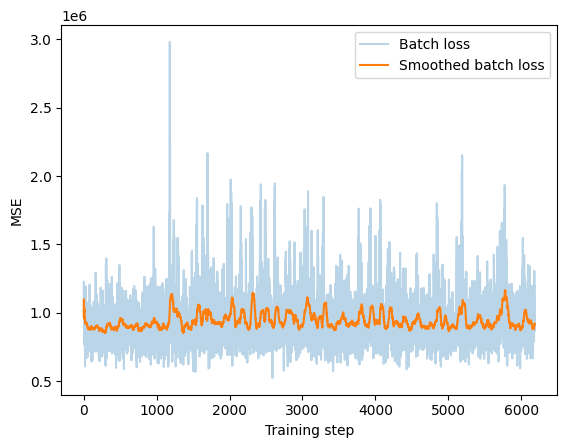

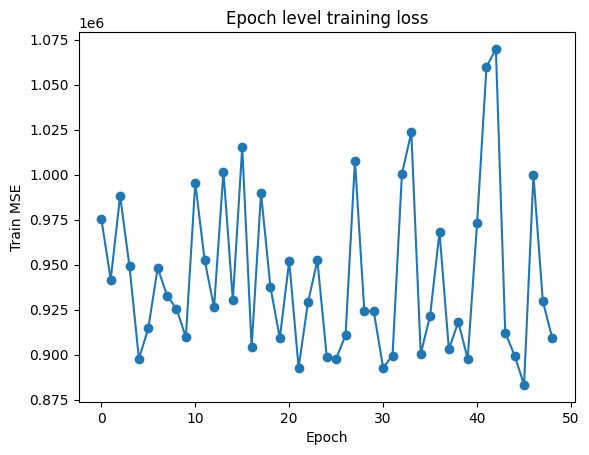

In [21]:
smoothed_batch_losses = moving_average(train_batch_losses[50:], window=50)
plt.figure()
plt.plot(train_batch_losses[50:], alpha=0.3, label="Batch loss")
plt.plot(smoothed_batch_losses, label="Smoothed batch loss")
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_epoch_losses[50:], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Train MSE")
plt.title("Epoch level training loss")
plt.show()